In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB

from sklearn.model_selection import learning_curve  # 画学习曲线的类
from sklearn.model_selection import ShuffleSplit  # 设定交叉验证模式的类
plt.style.use("ggplot")
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
news = pd.read_csv("./data/朴素贝叶斯-数据集/fake_news_detect/data.csv")

# 数据探索

In [3]:
news.head(3)

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1


In [4]:
# 查看每个网站的真假新闻数
news['website'] = news.URLs.apply(lambda x: x.split('/')[2])
news.pivot_table(index='website', columns='Label', values='URLs',
                 aggfunc='count').fillna(0).astype(int)

Label,0,1
website,,
abcnews.go.com,0,57
api.content-ad.net,2,0
beforeitsnews.com,1694,0
bleacherreport.com,0,8
clarivate.com,0,3
cnn.it,0,1
dailybuzzlive.com,99,0
edition.cnn.com,0,16
inhealth.cnn.com,0,14


**结果发现，这些可能都是人为标注的。**

**所以在接下来的预测中不会使用url。仅使用HeaLine和BodY**


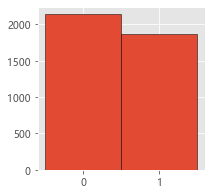

In [5]:
# 可以发现假新闻和真新闻数量基本相同

plt.figure(figsize=(3, 3))
plt.hist(news["Label"], 2, edgecolor='k')
plt.xticks([0.25, 0.75], [0, 1])
plt.show()

# 数据预处理

In [6]:
news["text"] = news["Headline"]+news["Body"]

In [7]:
news.head()

,URLs,Headline,Body,Label,website,text
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1,www.bbc.com,Four ways Bob Corker skewered Donald TrumpImag...
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1,www.reuters.com,Linklater's war veteran comedy speaks to moder...
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1,www.nytimes.com,Trump’s Fight With Corker Jeopardizes His Legi...
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1,www.reuters.com,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1,www.cnn.com,Jason Aldean opens 'SNL' with Vegas tributeCou...


In [8]:
news.drop(labels=["Headline", "Body", "URLs", "website"], axis=1, inplace=True)

In [9]:
news.head()

,Label,text
0,1,Four ways Bob Corker skewered Donald TrumpImag...
1,1,Linklater's war veteran comedy speaks to moder...
2,1,Trump’s Fight With Corker Jeopardizes His Legi...
3,1,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,1,Jason Aldean opens 'SNL' with Vegas tributeCou...


In [10]:
# 可以发现有21个null
news.isnull().sum()

Label     0
text     21
dtype: int64

In [11]:
# 因为无法填补，所以直接drop
news.dropna(inplace=True)

In [12]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3988 entries, 0 to 4008
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   3988 non-null   int64 
 1   text    3988 non-null   object
dtypes: int64(1), object(1)
memory usage: 93.5+ KB


In [13]:
print(news.isnull().sum())

news.count()

Label    0
text     0
dtype: int64


Label    3988
text     3988
dtype: int64

In [14]:
# 分割训练集测试集
x_train, x_test, y_train, y_test = train_test_split(
    news["text"], news["Label"], test_size=0.25)

In [15]:
x_train.head()

1473    Joe Flacco Goes on the DefensiveJoe Flacco Goe...
2567    Indian court acquits dentist couple of killing...
3692    Bar Owner Doesn't Think 'Lynch Kaepernick' Doo...
3060    Trump Offers Dems a Deal on Healthcare, Schume...
175     Hangover WinHangover Win\n% of readers think t...
Name: text, dtype: object

In [16]:
y_train.head()

1473    0
2567    1
3692    0
3060    0
175     0
Name: Label, dtype: int64

In [17]:
# tf-idf

tf = TfidfVectorizer()
x_train = tf.fit_transform(x_train)
x_test = tf.transform(x_test)

# 模型训练

In [18]:
# 用来画学习曲线
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

def learn_curve_plot(e,cv,x_train_array,y_train_array):
    
    train_sizes, train_scores, test_scores = learning_curve(
       e, x_train_array, y_train_array, cv=cv)
    plt.figure(figsize=(4,4))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    plt.legend(loc="best")

In [19]:
# 用来获取各个得分
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss


def get_score(e, x_train,y_train,x_test, y_test):
    e.fit(x_train, y_train)
    pred = e.predict(x_test)
    acc = e.score(x_test, y_test)
    brier = brier_score_loss(y_test, pred)
    log = log_loss(y_test, pred)
    print("正确率:%f" % acc)
    print("布里尔分数:%f" % brier)
    print("对数损失:%f" % log)
    return acc,brier,log

## 多项式贝叶斯

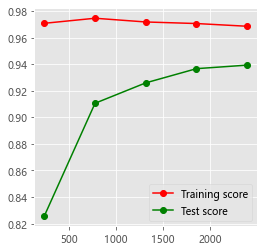

In [20]:
learn_curve_plot(MultinomialNB(),cv,x_train.toarray(),y_train)

In [21]:
score1 = get_score(MultinomialNB(),x_train,y_train, x_test, y_test)

正确率:0.930792
布里尔分数:0.069208
对数损失:2.390378


## 高斯贝叶斯

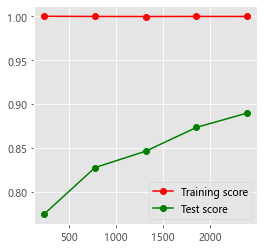

In [22]:
learn_curve_plot(GaussianNB(),cv,x_train.toarray(),y_train)

In [23]:
score2 = get_score(GaussianNB(),x_train.toarray(),y_train, x_test.toarray(), y_test)

正确率:0.897693
布里尔分数:0.102307
对数损失:3.533608


## 伯努利贝叶斯

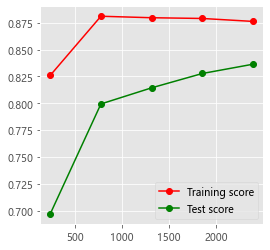

In [24]:
learn_curve_plot(BernoulliNB(),cv,x_train.toarray(),y_train)

In [25]:
score3 = get_score(GaussianNB(), x_train.toarray(),y_train,x_test.toarray(), y_test)

正确率:0.897693
布里尔分数:0.102307
对数损失:3.533608


## 补集贝叶斯

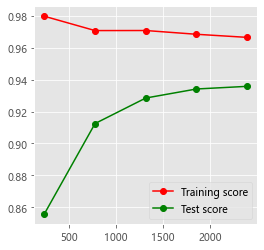

In [26]:
learn_curve_plot(ComplementNB(),cv,x_train.toarray(),y_train)

In [27]:
score4 = get_score(GaussianNB(), x_train.toarray(),y_train,x_test.toarray(), y_test)

正确率:0.897693
布里尔分数:0.102307
对数损失:3.533608


In [28]:
print("多项式：\t",score1)
print("高斯：\t",score2)
print("伯努利：\t",score3)
print("补集：\t",score4)

多项式：	 (0.9307923771313942, 0.06920762286860582, 2.390377889216264)
高斯：	 (0.8976930792377131, 0.10230692076228685, 3.5336079900841053)
伯努利：	 (0.8976930792377131, 0.10230692076228685, 3.5336079900841053)
补集：	 (0.8976930792377131, 0.10230692076228685, 3.5336079900841053)
